#Sentiment Analysis on Movie Reviews

Importing Libraries

In [37]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string, time
import nltk

from collections import Counter
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from imblearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

%matplotlib inline

Reading dataset as pandas dataframe

In [38]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
imdb_df = pd.read_csv('IMDB Dataset.csv', encoding='utf-8')
pd.set_option('display.max_colwidth', None)
pd.concat([imdb_df.head(),imdb_df.tail()])

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

In [40]:
# checking for null elements
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


sentiment
negative    25000
positive    25000
Name: count, dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

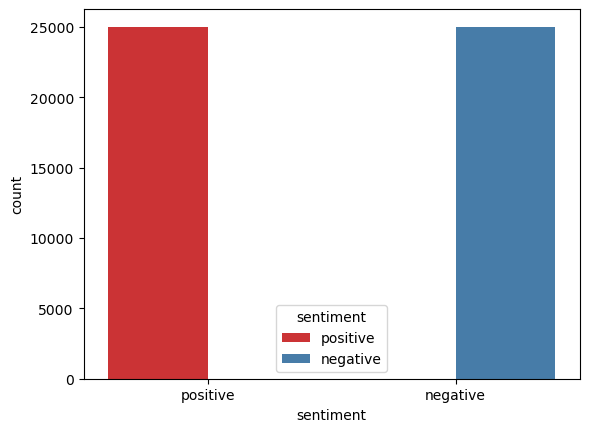

In [41]:
# checking for balance in dataset
print(imdb_df.value_counts('sentiment'))
sns.countplot(data=imdb_df, x ='sentiment' , palette = "Set1" , hue ='sentiment')

In [42]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",positive
freq,5,25000


In [43]:
# getting word counts for each review
pd.set_option('display.max_colwidth', 50)
imdb_df['word_count'] = imdb_df['review'].apply(lambda rev:len(rev.split()))
imdb_df.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


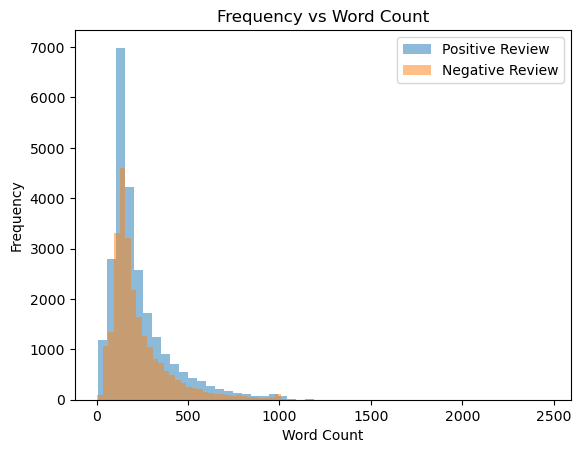

In [44]:
# mapping freq and word count for both classes

imdb_df[imdb_df.sentiment=='positive']['word_count'].plot.hist(bins=50, alpha=0.5, label='Positive Review')
imdb_df[imdb_df.sentiment=='negative']['word_count'].plot.hist(bins=50, alpha=0.5,  label='Negative Review')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Frequency vs Word Count')
plt.legend()
plt.show()

In [45]:
# applying class encoding
imdb_df['sentiment'] = imdb_df['sentiment'].map({"positive": 0, "negative": 1})

In [46]:
# listing down 50 most freq words
Counter(" ".join(imdb_df["review"]).split()).most_common(50)

[('the', 568735),
 ('a', 306960),
 ('and', 301919),
 ('of', 283625),
 ('to', 261850),
 ('is', 203056),
 ('in', 169981),
 ('I', 132498),
 ('that', 126818),
 ('this', 113726),
 ('it', 107916),
 ('/><br', 100974),
 ('was', 92658),
 ('as', 83130),
 ('with', 82569),
 ('for', 80919),
 ('The', 67317),
 ('but', 66282),
 ('on', 61197),
 ('movie', 60762),
 ('are', 56513),
 ('film', 54277),
 ('his', 54198),
 ('have', 54009),
 ('not', 52140),
 ('you', 50697),
 ('be', 50539),
 ('at', 42421),
 ('by', 42290),
 ('he', 42114),
 ('one', 41334),
 ('an', 41076),
 ('from', 37876),
 ('who', 37207),
 ('like', 36028),
 ('all', 35272),
 ('they', 35201),
 ('has', 32420),
 ('so', 32386),
 ('just', 32338),
 ('or', 32221),
 ('about', 32036),
 ('her', 29944),
 ('out', 28679),
 ('some', 28052),
 ('very', 25794),
 ('more', 25412),
 ('This', 24329),
 ('would', 23578),
 ('what', 23320)]

In [47]:
# shuffling dataset
imdb_df_sub = imdb_df.sample(frac=0.50, random_state=1)

In [48]:
# getting word counts for non-essential words
imdb_df_sub['hashtag']= imdb_df_sub['review'].apply(lambda rev: len ([x for x in rev.split() if x.startswith('#')]))
imdb_df_sub['mention']= imdb_df_sub['review'].apply(lambda rev: len ([x for x in rev.split() if x.startswith('@')]))
imdb_df_sub['url']= imdb_df_sub['review'].apply(lambda rev: len ([x for x in rev.split() if x.lower().startswith('https?:')]))

In [49]:
# defining the function to remove html tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

imdb_df_sub['review'] = imdb_df_sub['review'].apply(remove_html_tags)

C:\Users\hp\AppData\Local\Temp\ipykernel_8104\3927026597.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [50]:
# defining the function to remove urls
def remove_urls(text):
    pattern = re.compile(r'https?://\S+')
    return pattern.sub(r'', text)

imdb_df_sub['review'] = imdb_df_sub['review'].apply(remove_urls)

In [51]:
# defining the function to remove punctuations
exclude = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', exclude))

imdb_df_sub['review'] = imdb_df_sub['review'].apply(remove_punctuations)

In [52]:
imdb_df_sub=imdb_df_sub.drop(['hashtag','mention','url'],axis=1)

# defining the function to tokenize the reviews
imdb_df_sub['review_tokens'] = imdb_df_sub['review'].apply(nltk.word_tokenize)

In [53]:
imdb_df_sub.head()

,review,sentiment,word_count,review_tokens
26247,With No Dead Heroes you get stupid lines like ...,1,308,"[With, No, Dead, Heroes, you, get, stupid, lin..."
35067,I thought maybe maybe this could be good An ea...,1,190,"[I, thought, maybe, maybe, this, could, be, go..."
34590,An elite American military team which of cours...,1,309,"[An, elite, American, military, team, which, o..."
16668,Ridiculous horror film about a wealthy man Joh...,1,243,"[Ridiculous, horror, film, about, a, wealthy, ..."
12196,Well if you are one of those Katanas filmnuts ...,0,91,"[Well, if, you, are, one, of, those, Katanas, ..."


In [54]:
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

imdb_df_sub['review_no_stopwords']= imdb_df_sub['review_tokens'].apply(lambda x:remove_stopwords(x))
imdb_df_sub['word_count_no_stopword'] = imdb_df_sub['review_no_stopwords'].apply(lambda x:len(x))

In [55]:
imdb_df_sub.head()

,review,sentiment,word_count,review_tokens,review_no_stopwords,word_count_no_stopword
26247,With No Dead Heroes you get stupid lines like ...,1,308,"[With, No, Dead, Heroes, you, get, stupid, lin...","[With, No, Dead, Heroes, get, stupid, lines, l...",179
35067,I thought maybe maybe this could be good An ea...,1,190,"[I, thought, maybe, maybe, this, could, be, go...","[I, thought, maybe, maybe, could, good, An, ea...",111
34590,An elite American military team which of cours...,1,309,"[An, elite, American, military, team, which, o...","[An, elite, American, military, team, course, ...",174
16668,Ridiculous horror film about a wealthy man Joh...,1,243,"[Ridiculous, horror, film, about, a, wealthy, ...","[Ridiculous, horror, film, wealthy, man, John,...",133
12196,Well if you are one of those Katanas filmnuts ...,0,91,"[Well, if, you, are, one, of, those, Katanas, ...","[Well, one, Katanas, filmnuts, like, sure, app...",60


In [56]:
#defining the object for stemming
porter_stemmer = PorterStemmer()
#defining a function for stemming
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text
imdb_df_sub['review_stemmed']=imdb_df_sub['review_no_stopwords'].apply(lambda x: stemming(x))

In [57]:
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
imdb_df_sub['review_lemmed']=imdb_df_sub['review_no_stopwords'].apply(lambda x:lemmatizer(x))

In [58]:
imdb_df_sub.head()

,review,sentiment,word_count,review_tokens,review_no_stopwords,word_count_no_stopword,review_stemmed,review_lemmed
26247,With No Dead Heroes you get stupid lines like ...,1,308,"[With, No, Dead, Heroes, you, get, stupid, lin...","[With, No, Dead, Heroes, get, stupid, lines, l...",179,"[with, no, dead, hero, get, stupid, line, like...","[With, No, Dead, Heroes, get, stupid, line, li..."
35067,I thought maybe maybe this could be good An ea...,1,190,"[I, thought, maybe, maybe, this, could, be, go...","[I, thought, maybe, maybe, could, good, An, ea...",111,"[i, thought, mayb, mayb, could, good, an, earl...","[I, thought, maybe, maybe, could, good, An, ea..."
34590,An elite American military team which of cours...,1,309,"[An, elite, American, military, team, which, o...","[An, elite, American, military, team, course, ...",174,"[an, elit, american, militari, team, cours, ha...","[An, elite, American, military, team, course, ..."
16668,Ridiculous horror film about a wealthy man Joh...,1,243,"[Ridiculous, horror, film, about, a, wealthy, ...","[Ridiculous, horror, film, wealthy, man, John,...",133,"[ridicul, horror, film, wealthi, man, john, ca...","[Ridiculous, horror, film, wealthy, man, John,..."
12196,Well if you are one of those Katanas filmnuts ...,0,91,"[Well, if, you, are, one, of, those, Katanas, ...","[Well, one, Katanas, filmnuts, like, sure, app...",60,"[well, one, katana, filmnut, like, sure, appre...","[Well, one, Katanas, filmnuts, like, sure, app..."


In [59]:
# converting stemmed and lemmed tokens to complete sentences
imdb_df_sub['proccessed_review_lemmed']=imdb_df_sub['review_lemmed'].apply(lambda x: ' '.join(x))
imdb_df_sub['proccessed_review_stemmed']=imdb_df_sub['review_lemmed'].apply(lambda x: ' '.join(x))
imdb_df_sub.head()

,review,sentiment,word_count,review_tokens,review_no_stopwords,word_count_no_stopword,review_stemmed,review_lemmed,proccessed_review_lemmed,proccessed_review_stemmed
26247,With No Dead Heroes you get stupid lines like ...,1,308,"[With, No, Dead, Heroes, you, get, stupid, lin...","[With, No, Dead, Heroes, get, stupid, lines, l...",179,"[with, no, dead, hero, get, stupid, line, like...","[With, No, Dead, Heroes, get, stupid, line, li...",With No Dead Heroes get stupid line like woefu...,With No Dead Heroes get stupid line like woefu...
35067,I thought maybe maybe this could be good An ea...,1,190,"[I, thought, maybe, maybe, this, could, be, go...","[I, thought, maybe, maybe, could, good, An, ea...",111,"[i, thought, mayb, mayb, could, good, an, earl...","[I, thought, maybe, maybe, could, good, An, ea...",I thought maybe maybe could good An early appe...,I thought maybe maybe could good An early appe...
34590,An elite American military team which of cours...,1,309,"[An, elite, American, military, team, which, o...","[An, elite, American, military, team, course, ...",174,"[an, elit, american, militari, team, cours, ha...","[An, elite, American, military, team, course, ...",An elite American military team course happens...,An elite American military team course happens...
16668,Ridiculous horror film about a wealthy man Joh...,1,243,"[Ridiculous, horror, film, about, a, wealthy, ...","[Ridiculous, horror, film, wealthy, man, John,...",133,"[ridicul, horror, film, wealthi, man, john, ca...","[Ridiculous, horror, film, wealthy, man, John,...",Ridiculous horror film wealthy man John Carrad...,Ridiculous horror film wealthy man John Carrad...
12196,Well if you are one of those Katanas filmnuts ...,0,91,"[Well, if, you, are, one, of, those, Katanas, ...","[Well, one, Katanas, filmnuts, like, sure, app...",60,"[well, one, katana, filmnut, like, sure, appre...","[Well, one, Katanas, filmnuts, like, sure, app...",Well one Katanas filmnuts like sure appreciate...,Well one Katanas filmnuts like sure appreciate...


In [60]:
Counter(" ".join(imdb_df_sub["proccessed_review_lemmed"]).split()).most_common(50)

[('I', 68250),
 ('movie', 49226),
 ('film', 44113),
 ('The', 37651),
 ('one', 24359),
 ('like', 19025),
 ('time', 14337),
 ('good', 13649),
 ('character', 13336),
 ('This', 12662),
 ('would', 11865),
 ('get', 11774),
 ('story', 11731),
 ('make', 11597),
 ('see', 11484),
 ('really', 11085),
 ('It', 10949),
 ('even', 10620),
 ('scene', 10164),
 ('much', 9170),
 ('people', 8719),
 ('bad', 8493),
 ('great', 8175),
 ('way', 8019),
 ('show', 7884),
 ('thing', 7852),
 ('well', 7808),
 ('made', 7739),
 ('first', 7639),
 ('also', 7494),
 ('could', 7398),
 ('think', 7374),
 ('dont', 7282),
 ('know', 6909),
 ('life', 6801),
 ('go', 6698),
 ('seen', 6550),
 ('watch', 6411),
 ('But', 6370),
 ('many', 6361),
 ('say', 6303),
 ('actor', 6279),
 ('plot', 6195),
 ('never', 6085),
 ('love', 6053),
 ('Its', 6046),
 ('look', 6043),
 ('two', 6041),
 ('And', 6020),
 ('acting', 5998)]

In [61]:
def model(df):
    """
    This function performs sentiment analysis on a given dataframe using the Multinomial Naive Bayes classifier.

    Parameters:
    df (pandas.DataFrame): A dataframe containing the reviews and their corresponding sentiments. 
                           The dataframe should have 'proccessed_review_lemmed' and 'sentiment' columns.

    Returns:
    dict: A dictionary containing the confusion matrix and the classification report of the model's performance.
          The dictionary has the following structure:
          {
              "confusion_matrix": (numpy.ndarray) The confusion matrix of the model's predictions,
              "classification_report": (str) The classification report providing a summary of the precision, recall, F1 score for each class.
          }
    """
    x_train, x_test, y_train, y_test = train_test_split(df['proccessed_review_lemmed'], df['sentiment'], test_size=0.3, random_state=1)
    tfidf_vectorizer = TfidfVectorizer(lowercase=True)    
    x_train_transformed = tfidf_vectorizer.fit_transform(x_train)
    x_test_transformed = tfidf_vectorizer.transform(x_test)
    model_mnb = MultinomialNB(alpha = 1)
    model_mnb.fit(x_train_transformed, y_train)
    predictions = model_mnb.predict(x_test_transformed)
    classification_report_op = classification_report(y_test, predictions,zero_division=0)
    confusion_matrix_op = confusion_matrix(y_test, predictions)

    return {"confusion_matrix": confusion_matrix_op, "classification_report": classification_report_op}

### Confusion Matrix: 
This is a table used to describe the performance of a classification model. It outlines four outcomes:

### Accuracy:
This is the ratio of correctly predicted reviews (both positive and negative) to the total number of reviews. It gives us an overall idea of how often the classifier is correct, but it might be misleading if classes are imbalanced.

### Precision:
Precision is the ratio of true positives (TP) to the sum of true and false positives (TP + FP). It represents the model's accuracy in classifying a review as positive.

### Recall:
Recall is the ratio of true positives (TP) to the sum of true positives and false negatives (TP + FN). It indicates how many of the actual positive reviews were captured by the model. It answers the question, "Of all actual positive reviews, how many did we correctly predict?"

### F1-Score: 
This is the harmonic mean of precision and recall, providing a balance between the two metrics. It ranges from 0 to 1, where 1 indicates perfect precision and recall, and is particularly useful in cases of uneven class distribution.

In [62]:
def create_imbalanced_dataset(data, positive_ratio):
    """
    Create an imbalanced dataset by undersampling the majority class.

    Parameters
    ----------
    data : pandas.DataFrame
        The original dataset.
    positive_ratio : float
        The ratio of positive to negative samples in the resulting dataset.

    Returns
    -------
    pandas.DataFrame
        The imbalanced dataset.
    """

    positive_reviews = data[data['sentiment'] == 0]
    negative_reviews = data[data['sentiment'] == 1]

    # Calculate the number of positive reviews to sample
    if (positive_ratio < 1):
        num_positive = int(len(negative_reviews) * positive_ratio)
        # Sample from positive reviews without replacement
        positive_sample = positive_reviews.sample(n=num_positive, replace=False)

        imbalanced_data = pd.concat([negative_reviews, positive_sample])
    else:
        num_negative = int(len(positive_reviews) * (1/positive_ratio))

        negative_sample = negative_reviews.sample(n=num_negative, replace=False)

        imbalanced_data = pd.concat([positive_reviews, negative_sample])
        
        imbalanced_data = imbalanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return imbalanced_data

We use sampling without replacement to maintain data integrity and avoid duplicate records, which could bias our model. The sample method from pandas is utilized for this purpose. The positive and negative samples are then concatenated to form the imbalanced dataset. Finally, the dataset is shuffled to ensure randomness, helping in unbiased model training later on.

<Axes: xlabel='sentiment', ylabel='count'>

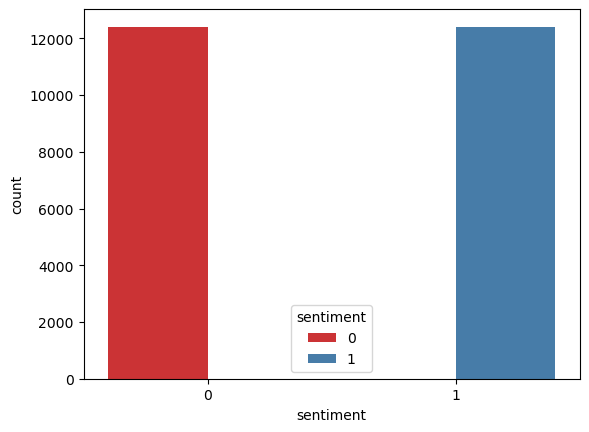

In [63]:
imdb_df_1x = create_imbalanced_dataset(imdb_df_sub, 1)
sns.countplot(data=imdb_df_1x, x ='sentiment' , palette = "Set1" , hue ='sentiment')

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3738
           1       0.84      0.88      0.86      3707

    accuracy                           0.86      7445
   macro avg       0.86      0.86      0.86      7445
weighted avg       0.86      0.86      0.86      7445



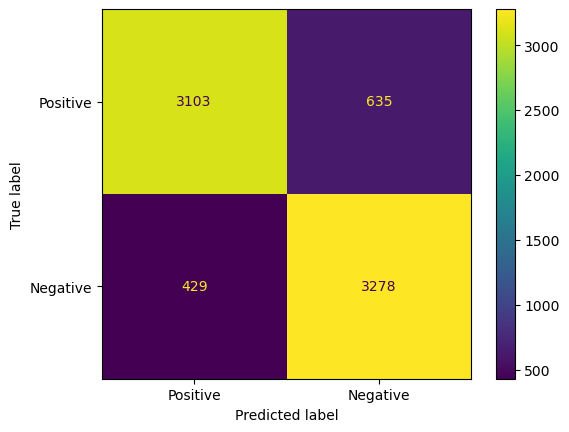

In [64]:
result = model(imdb_df_1x)
cm = result['confusion_matrix']
cr = result['classification_report']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive','Negative'])
print(cr)
disp.plot()

<Axes: xlabel='sentiment', ylabel='count'>

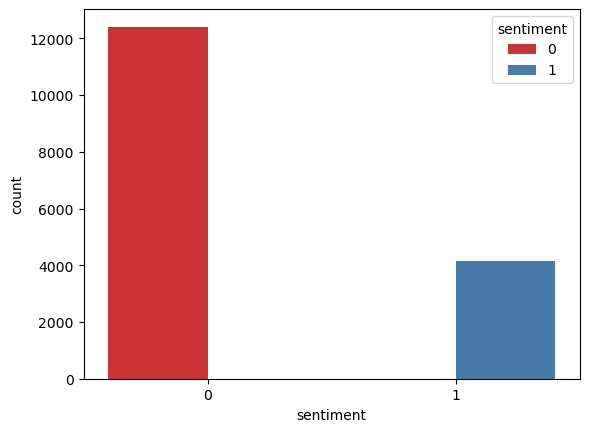

In [65]:
imdb_df_3x = create_imbalanced_dataset(imdb_df_sub, 3)
sns.countplot(data=imdb_df_3x, x ='sentiment' , palette = "Set1" , hue ='sentiment')

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3718
           1       0.00      0.00      0.00      1246

    accuracy                           0.75      4964
   macro avg       0.37      0.50      0.43      4964
weighted avg       0.56      0.75      0.64      4964



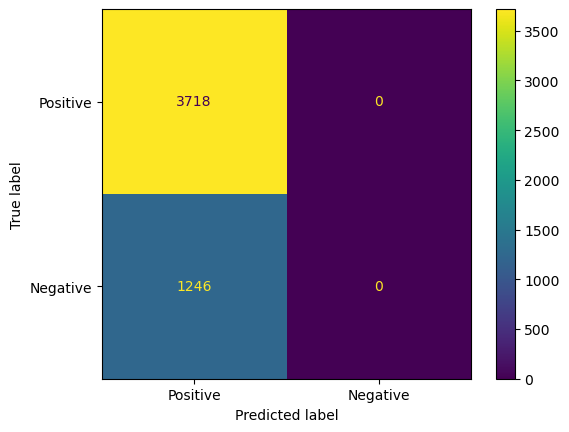

In [66]:
result = model(imdb_df_3x)
cm = result['confusion_matrix']
cr = result['classification_report']
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive','Negative'])
print(cr)
display_cm.plot()

<Axes: xlabel='sentiment', ylabel='count'>

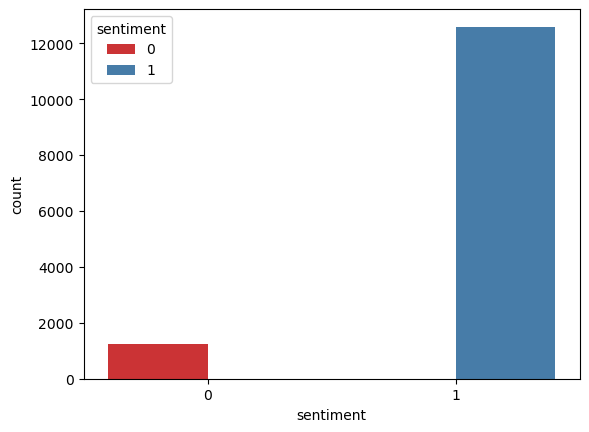

In [67]:
imdb_df_01x = create_imbalanced_dataset(imdb_df_sub, 0.1)
sns.countplot(data=imdb_df_01x, x ='sentiment' , palette = "Set1" , hue ='sentiment')


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       371
           1       0.91      1.00      0.95      3785

    accuracy                           0.91      4156
   macro avg       0.46      0.50      0.48      4156
weighted avg       0.83      0.91      0.87      4156



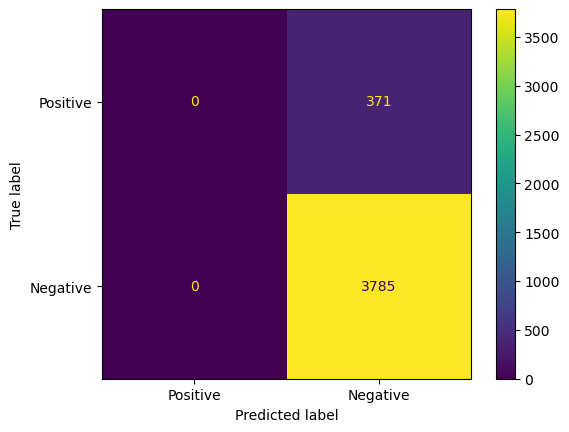

In [68]:
result = model(imdb_df_01x)
cm = result['confusion_matrix']
cr = result['classification_report']
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive','Negative'])
print(cr)
display_cm.plot()

<Axes: xlabel='sentiment', ylabel='count'>

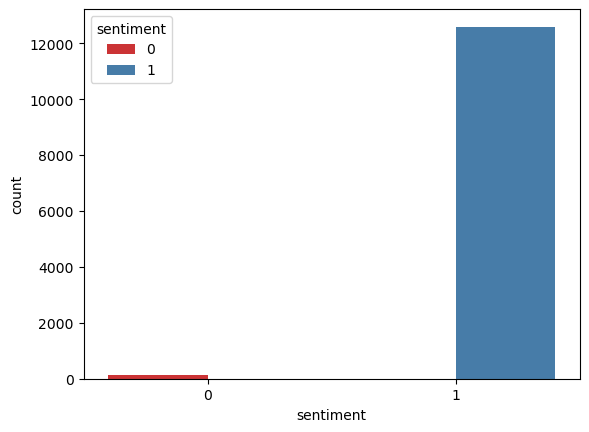

In [69]:
imdb_df_001x = create_imbalanced_dataset(imdb_df_sub, 0.01)
sns.countplot(data=imdb_df_001x, x ='sentiment' , palette = "Set1" , hue ='sentiment')



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.99      1.00      0.99      3777

    accuracy                           0.99      3816
   macro avg       0.49      0.50      0.50      3816
weighted avg       0.98      0.99      0.98      3816



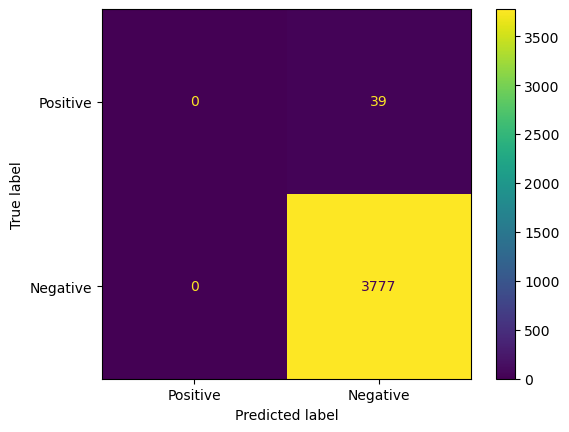

In [70]:
result = model(imdb_df_001x)
cm = result['confusion_matrix']
cr = result['classification_report']
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive','Negative'])
print(cr)
display_cm.plot()

When we ran the model on datasets with positive ratios of 10% and 1%, we are likely to observe a significant shift in performance metrics, particularly in precision, recall, and F1-score for the positive class.

Even with the class imbalance, we got overall accuracy of the model as 91% and 99% which is significantly very high. This is due to the accuracy paradox, where the model might lean towards predicting the majority class (negative reviews in this case) and still achieve a high number of correct predictions. However, this doesn't mean the model is performing well.

The model's precision and recall for the positive class also showed significant drop. This is because, with fewer positive samples, the model has very less data to learn what constitutes a positive review, leading to more false negatives.

The F1-score for the positive class also dropped significantly due to lower precision and recall. Since it's the harmonic mean of precision and recall, it's sensitive to a drop in either metric and provides a more realistic picture of the model's performance on imbalanced data.

The model behaves this way primarily because most machine learning models, assume that the data is equally distributed and often fail to perform well with imbalanced datasets. They tend to favor the majority class during training, leading to a bias towards it. As a result, the model becomes less sensitive to the minority class, causing the shifts in performance metrics observed.

              precision    recall  f1-score   support

           0       0.47      0.63      0.54       252
           1       0.96      0.93      0.94      2519

    accuracy                           0.90      2771
   macro avg       0.71      0.78      0.74      2771
weighted avg       0.92      0.90      0.91      2771



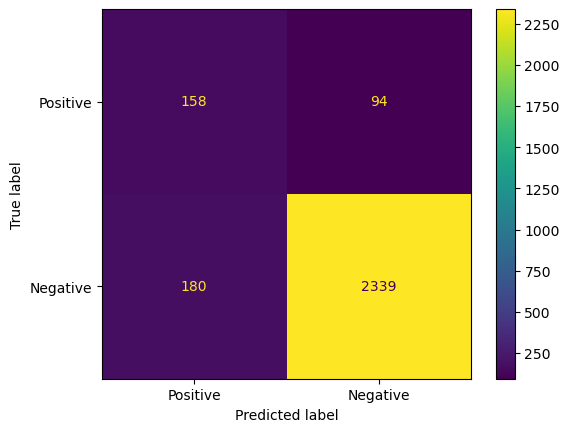

In [71]:
import numpy as np
#Assume 'imbalanced_data' is your dataset with a 1% positive ratio
review = imdb_df_01x['review']
sentiment = imdb_df_01x['sentiment']

vectorizer = TfidfVectorizer()

review_vect = vectorizer.fit_transform(review)

x_train, x_test, y_train, y_test = train_test_split(review_vect, sentiment, test_size=0.2, random_state=42)

# Use SMOTE to balance the training data
sm = SMOTE(random_state=42, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

model = MultinomialNB() 
model.fit(x_train_res, y_train_res)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
display_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Positive','Negative'])
display_cm.plot()
